In [2]:
from helper_functions import plot_loss_curves, create_tensorboard_callback, unzip_data, walk_through_dir

## Lets Get some Data 

This time lets use some pretrained models for tf.keras.applications

In [3]:
walk_through_dir('10_food_classes_10_percent/')

There are 4 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [4]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [5]:
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, 
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical',
                                                                           batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode='categorical',
                                                               batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building a transfer learning model using the Keras Functional API

In [7]:
# Create the base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

#Freeze the base model (so the pretrained patterns aren't updated during training)
base_model.trainable = False

#Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

#If using a model like ResNet50V2 you will need to normalize the inputs (Efficient net is built in already)
# x = tf.keras.layers.Rescaling(1./255)(inputs)

# Pass the input to the base_model
x = base_model(inputs)
print(x.shape)

# Average Pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(x.shape)

#Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Combine the inputs with teh outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

#compile the model
model_0.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

#fit the model
history_1 = model_0.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data, validation_steps=int(0.25 * len(test_data)),callbacks=[create_tensorboard_callback('transfer_learning','10_percent_feature_extraction')])

(None, 7, 7, 1280)
(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240318-112202
Epoch 1/5
24/24 [==============================] - 11s 379ms/step - loss: 1.8768 - accuracy: 0.4347 - val_loss: 1.3270 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 8s 357ms/step - loss: 1.1414 - accuracy: 0.7493 - val_loss: 0.8884 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - 8s 358ms/step - loss: 0.8436 - accuracy: 0.8040 - val_loss: 0.7340 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 9s 361ms/step - loss: 0.7008 - accuracy: 0.8387 - val_loss: 0.6110 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 9s 359ms/step - loss: 0.5977 - accuracy: 0.8600 - val_loss: 0.5660 - val_accuracy: 0.8635


In [8]:
model_0.evaluate(test_data)

79/79 [==============================] - 15s 193ms/step - loss: 0.5668 - accuracy: 0.8560


[0.5668066143989563, 0.8560000061988831]

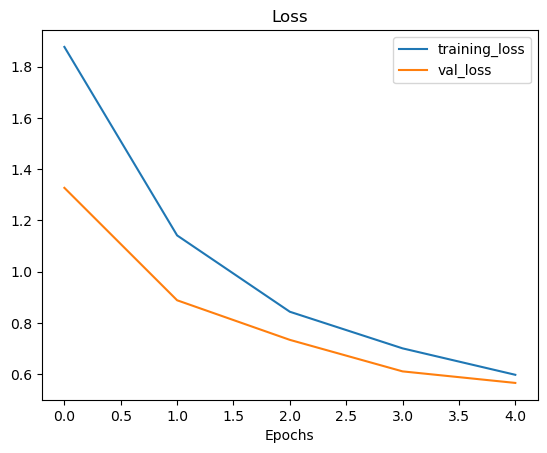

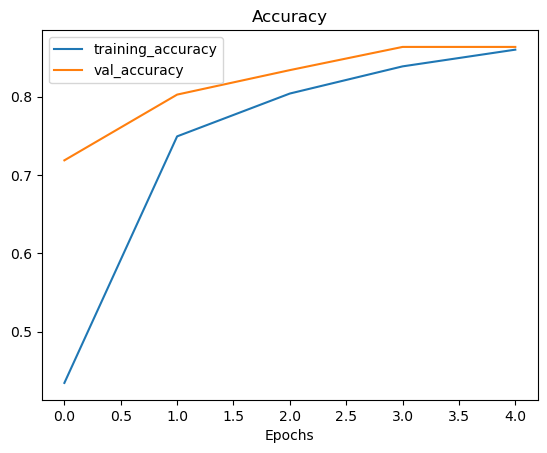

In [9]:
plot_loss_curves(history_1)

## Getting a Feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through 'base_model' of shape (None, 7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Lets use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [10]:
#Define the input shape
input_shape = (1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.26454744]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.891714  , -0.9384712 ]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728497,  0.40125778, -1.4145442 ],
         [-0.59318566, -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.2347968 , -0.56668764],
         [-0.35819843,  0.88698626,  0.5274477 ]]]], dtype=float32)>

In [12]:
#pass the random tensor through a global average pooling 2d layer
global_average = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average.shape

TensorShape([1, 3])

In [13]:
global_max = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
global_max

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of Transfer Learning Experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data?

1. model_1 - use feature extraction transfer learning with 1% of the training data with augmentation
2. model_2 - use feature extraction transfer learning with 10% of the training data with augmentation
3. model_3 - use fine-tuning transfer leanring on 10% of the training data with data augmentation
4. model_4 - use fine-tuning transfer learning on 100% of the training data with data augmentation

In [14]:
#Download and unzip data
unzip_data('10_food_classes_1_percent.zip')

In [15]:
#Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [16]:
walk_through_dir('10_food_classes_1_percent/')

There are 2 directories and 0 images in '10_food_classes_1_percent/'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice

In [18]:
#Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode='categorical',
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='categorical', image_size=IMG_SIZE, batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation into the model

To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) #If it is a neural net that does not include this but Efficientnet does!
], name='data_augmentation')

### Visualize our data augmentation layer and see what happens to our data

ramen
10_food_classes_1_percent/train/ramen
1622569.jpg
10_food_classes_1_percent/train/ramen/1622569.jpg
(1, 450, 343, 3)


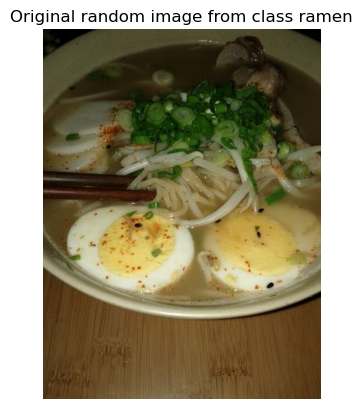

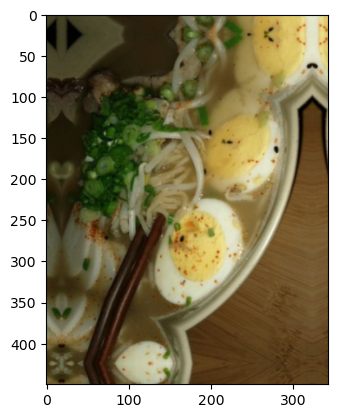

In [47]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
print(target_class)
target_dir = '10_food_classes_1_percent/train/' + target_class
print(target_dir)
random_image = random.choice(os.listdir(target_dir))
print(random_image)
random_image_path = target_dir + '/' + random_image
print(random_image_path)

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class {target_class}')
plt.axis(False)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
print(augmented_img.shape)
plt.figure()
plt.imshow(tf.squeeze(augmented_img) / 255.)

In [27]:
#Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

#Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)

output = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_1 = keras.Model(inputs, output)

model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

history_1_percent = model_1.fit(train_data_1_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_1_percent),
                               validation_data=test_data, 
                               validation_steps=int(0.25 * len(test_data)))

Epoch 1/5
3/3 [==============================] - 7s 2s/step - loss: 2.3550 - accuracy: 0.1429 - val_loss: 2.2005 - val_accuracy: 0.1546
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1148 - accuracy: 0.2286 - val_loss: 2.0905 - val_accuracy: 0.2812
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9417 - accuracy: 0.3429 - val_loss: 1.9982 - val_accuracy: 0.3618
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8008 - accuracy: 0.4857 - val_loss: 1.9072 - val_accuracy: 0.4309
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6715 - accuracy: 0.6000 - val_loss: 1.8134 - val_accuracy: 0.4885


In [32]:
model_1_1 = tf.keras.Sequential()
model_1_1.add(base_model)
model_1_1.add(tf.keras.layers.GlobalAveragePooling2D())
model_1_1.add(tf.keras.layers.Dense(10,activation='softmax'))

model_1_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model_1_1.fit(train_data_1_percent, epochs=5, steps_per_epoch=len(train_data_1_percent), validation_data=test_data, validation_steps=int(0.25 * len(test_data)))

Epoch 1/5
3/3 [==============================] - 7s 2s/step - loss: 2.3084 - accuracy: 0.1286 - val_loss: 2.0942 - val_accuracy: 0.2697
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0297 - accuracy: 0.2571 - val_loss: 1.9476 - val_accuracy: 0.3914
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8371 - accuracy: 0.5143 - val_loss: 1.8454 - val_accuracy: 0.4605
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.6317 - accuracy: 0.6571 - val_loss: 1.7504 - val_accuracy: 0.4918
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.4837 - accuracy: 0.7429 - val_loss: 1.6387 - val_accuracy: 0.5609


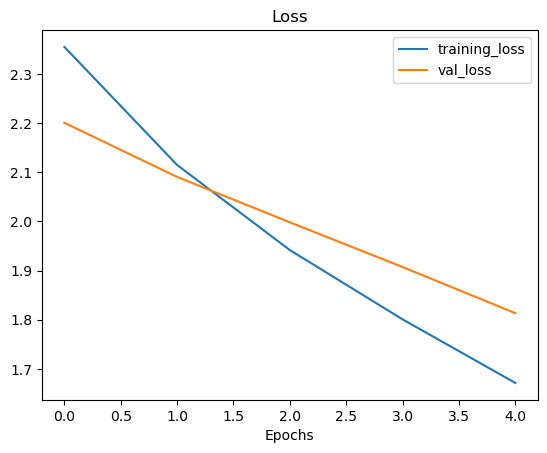

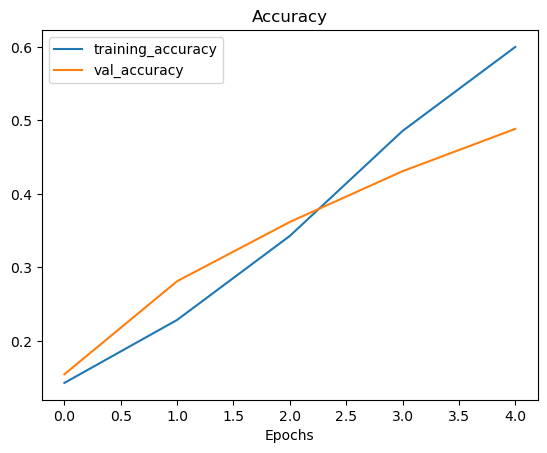

In [33]:
plot_loss_curves(history_1_percent)

In [36]:
model_1.evaluate(test_data)

79/79 [==============================] - 15s 193ms/step - loss: 1.8181 - accuracy: 0.4848


[1.8180568218231201, 0.4848000109195709]

In [37]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [38]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent, label_mode='categorical', batch_size=32, image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='categorical', batch_size=32, image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [39]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [48]:
INPUT_SHAPE = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])

history_2 = model_2.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent), validation_data=test_data, validation_steps=(0.25 * len(test_data)))

Epoch 1/5
24/24 [==============================] - 13s 417ms/step - loss: 1.9709 - accuracy: 0.3480 - val_loss: 1.4641 - val_accuracy: 0.6578
Epoch 2/5
24/24 [==============================] - 9s 380ms/step - loss: 1.3947 - accuracy: 0.6333 - val_loss: 1.0566 - val_accuracy: 0.7625
Epoch 3/5
24/24 [==============================] - 9s 397ms/step - loss: 1.0802 - accuracy: 0.7400 - val_loss: 0.8331 - val_accuracy: 0.8016
Epoch 4/5
24/24 [==============================] - 9s 380ms/step - loss: 0.9397 - accuracy: 0.7667 - val_loss: 0.7455 - val_accuracy: 0.8125
Epoch 5/5
24/24 [==============================] - 9s 395ms/step - loss: 0.8364 - accuracy: 0.7813 - val_loss: 0.6668 - val_accuracy: 0.8188


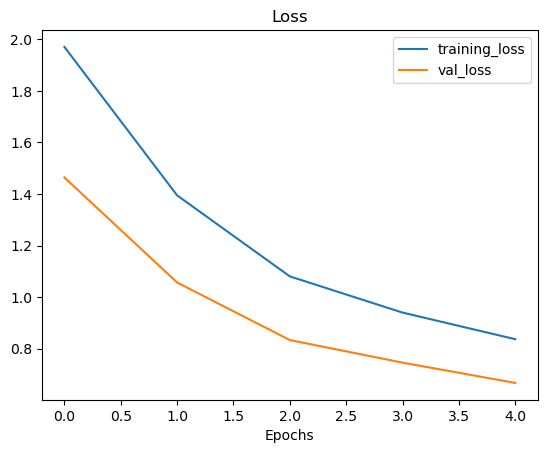

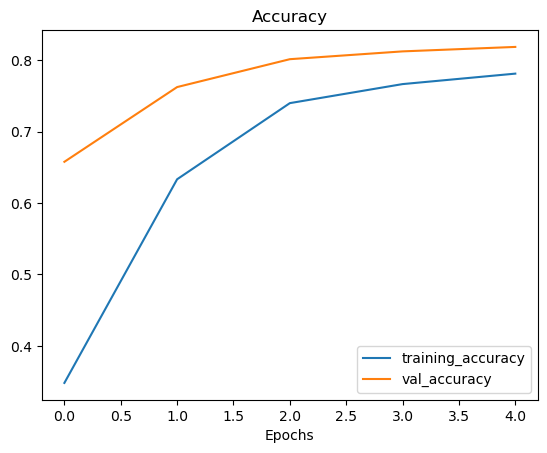

In [49]:
plot_loss_curves(history_2)

In [50]:
model_2.evaluate(test_data)

79/79 [==============================] - 15s 189ms/step - loss: 0.6616 - accuracy: 0.8244


[0.6615504622459412, 0.824400007724762]

### Creating a model Checkpoint callback

The ModelCheckpoint callback intermediately saves our model(the ful model or just the weights) during training. This is useful so we can come and start where we left off.

In [52]:
#Set checkpoint path 
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

#Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq='epoch',
                                                         verbose=1)

In [53]:
model_2_2 = tf.keras.Model(inputs, outputs)

model_2_2.compile(loss='categorical_crossentropy',
                 optimizer = tf.keras.optimizers.legacy.Adam(),
                 metrics=['accuracy'])

history_2_2 = model_2_2.fit(train_data_10_percent, epochs=5,
                            steps_per_epoch=len(train_data_10_percent), validation_data=test_data,
                            validation_steps=(0.25 * len(test_data)), callbacks=[checkpoint_callback])

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.7507 - accuracy: 0.8187
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 418ms/step - loss: 0.7507 - accuracy: 0.8187 - val_loss: 0.6132 - val_accuracy: 0.8266
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.8387
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 403ms/step - loss: 0.6848 - accuracy: 0.8387 - val_loss: 0.5509 - val_accuracy: 0.8469
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.8413
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 386ms/step - loss: 0.6273 - accuracy: 0.8413 - val_loss: 0.5309 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.5873 - accuracy: 0.8

### Loading in checkpointed weights

Loading in checkpointed weights returns the model to a specific checkpoint

In [54]:
#Load in saved model weights and evaluate the model
model_2.load_weights(checkpoint_path)

In [56]:
model_2_2.evaluate(test_data)

79/79 [==============================] - 16s 196ms/step - loss: 0.4832 - accuracy: 0.8468


[0.4831894636154175, 0.8468000292778015]

In [55]:
loaded_weights_model_reults = model_2.evaluate(test_data)

79/79 [==============================] - 15s 193ms/step - loss: 0.4832 - accuracy: 0.8468


## Model 3

* 10 percent training datasets
* Data Augmentation step
* Fine tuning the pretrained model 

In [58]:
#Layers in loaded model 
model_2.layers

In [59]:
#Are they trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x2eddadb10> True
<keras.src.engine.sequential.Sequential object at 0x2d5edd310> True
<keras.src.engine.functional.Functional object at 0x2a7c97f90> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x2a7c83250> True
<keras.src.layers.core.dense.Dense object at 0x2a8032250> True


In [ ]:
for i,layer in enumerate(model_2.layers[2].layers):
    print(i,layer.name, layer.trainable)

In [61]:
#How many of the layers are trainable?
print(len(model_2.layers[2].trainable_variables))

0


In [66]:
# To begin fine tuning lets start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

#Recompile (we have to recompile anytime a change is made)
#When fine tuning you typically want to lower the learning rate by 10x
model_2.compile(loss='categorical_crossentropy',
               optimizer = tf.keras.optimizers.legacy.Adam(.0001),
               metrics=['accuracy'])

In [ ]:
#Check which layers are tunable 
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

In [67]:
#Fine Tune for another 5 epochs
history_fine_tune = model_2.fit(train_data_10_percent, epochs=10, validation_data=test_data, validation_steps=int(0.25 * len(test_data)),
                               initial_epoch=history_2_2.epoch[-1])

Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.4857 - accuracy: 0.8667
Epoch 5: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 457ms/step - loss: 0.4857 - accuracy: 0.8667 - val_loss: 0.4584 - val_accuracy: 0.8470
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.4155 - accuracy: 0.8787
Epoch 6: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 429ms/step - loss: 0.4155 - accuracy: 0.8787 - val_loss: 0.4187 - val_accuracy: 0.8618
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.3848 - accuracy: 0.8880
Epoch 7: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 468ms/step - loss: 0.3848 - accuracy: 0.8880 - val_loss: 0.4526 - val_accuracy: 0.8487
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.3549 - accuracy

## Model 4 
Fine tuning a model on 100% of the data

In [68]:
unzip_data('10_food_classes_all_data.zip')

In [69]:
walk_through_dir('10_food_classes_all_data/')

There are 2 directories and 0 images in '10_food_classes_all_data/'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are

In [70]:
train_dir_all = '10_food_classes_all_data/train'
test_dir_all = '10_food_classes_all_data/test'

In [71]:
#Setup data inputs
IMG_SIZE = (224,224)

train_data_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all, image_size=IMG_SIZE, label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_all, image_size=IMG_SIZE, label_mode='categorical')

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [73]:
#Load weights from checkpoint
model_2.load_weights(checkpoint_path)

In [74]:
#Check which layers are tunable in the model
for i, layer in enumerate(model_2.layers):
    print(i, layer.name, layer.trainable)

0 input_11 True
1 sequential_2 True
2 efficientnetv2-b0 True
3 global_average_pooling2d_6 True
4 dense_3 True


In [ ]:
#Lets drill into our base model and see which layers are trainable
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

In [79]:
model_2.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.legacy.Adam(.0001), metrics=['accuracy'])

history_3 = model_2.fit(train_data_full, epochs=10, initial_epoch=history_2_2.epoch[-1], validation_data=test_data, validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
235/235 [==============================] - 65s 269ms/step - loss: 0.6216 - accuracy: 0.8005 - val_loss: 0.3512 - val_accuracy: 0.8832
Epoch 6/10
235/235 [==============================] - 64s 271ms/step - loss: 0.5476 - accuracy: 0.8245 - val_loss: 0.3387 - val_accuracy: 0.8816
Epoch 7/10
235/235 [==============================] - 64s 271ms/step - loss: 0.5113 - accuracy: 0.8371 - val_loss: 0.2847 - val_accuracy: 0.9112
Epoch 8/10
235/235 [==============================] - 63s 267ms/step - loss: 0.4714 - accuracy: 0.8460 - val_loss: 0.2890 - val_accuracy: 0.9030
Epoch 9/10
235/235 [==============================] - 64s 270ms/step - loss: 0.4449 - accuracy: 0.8565 - val_loss: 0.2792 - val_accuracy: 0.9112
Epoch 10/10
235/235 [==============================] - 63s 266ms/step - loss: 0.4243 - accuracy: 0.8605 - val_loss: 0.2644 - val_accuracy: 0.9178


In [80]:
model_2.evaluate(test_data)

79/79 [==============================] - 16s 207ms/step - loss: 0.2538 - accuracy: 0.9212


[0.25382137298583984, 0.9211999773979187]